In [11]:
import os, sys

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from glob import glob

from scipy.stats import pearsonr
from matplotlib.ticker import MultipleLocator



In [12]:
data_dir = '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/combined/'

In [13]:
data_files = glob(data_dir + '*')
data_files

['/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/combined/CLNX_1999_2019.24h.isobaric.pd',
 '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/combined/CLNX_1999_2019.12h.isobaric.pd',
 '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/combined/ALTA_1980_2020.24h.isobaric.pd',
 '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/combined/AGD_2004_2019.24h.isobaric.pd',
 '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/combined/AGD_2004_2019.12h.isobaric.pd',
 '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/combined/SLB_1980_2020.24h.isobaric.pd',
 '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/combined/BCC_2004_2019.24h.isobaric.pd',
 '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/combined/BCC_2004_2019.12h.isobaric.pd',
 '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessle

In [14]:
model = 'ERA5'
site, interval = 'BCC', 24
var_type = 'mean' #max, min
max_level, min_level = 1000, 200

data_file = glob(data_dir + '%s*.*%02dh*.pd'%(site, interval))[0]
print(data_file, '\n')

data = pd.read_pickle(data_file)

var_keys = np.append(['slr', 'swe_mm'], [k for k in data.keys() if var_type in k])
data = data[var_keys].rename(columns={k:k.replace('_mean', '') for k in var_keys})

era_levels, era_vars = [], []
for k in data.keys():
    try:
        level = int(k.split('_')[1])
    except:
        pass
    else:
        if ((level <= max_level) & (level >= min_level)):
            era_levels.append(level)
            era_vars.append(k.split('_')[0])
            
era_levels = np.unique(era_levels)
era_vars = np.unique(era_vars)

/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/combined/BCC_2004_2019.24h.isobaric.pd 



In [15]:
meta_file = glob(data_dir + '../*Metadata*.xlsx')[0]
metadata = pd.read_excel(meta_file)

# Temp fix to use CLNX instead of CLN data
metadata['code'] = metadata['code'].replace('CLN', 'CLNX')
metadata = metadata.set_index('code').loc['CLNX']

# Determine the lat, lon of the site from the metadata
site_lat, site_lon = metadata['lat'], metadata['lon']
site_elev = metadata['elevation_m']

# Import the era5_orog file to check the lat/lon grid
era_dir = '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/era5/'
era5_orog_file = era_dir + 'era5_orog.nc'
era5_orog = xr.open_dataset(era5_orog_file)['z'].isel(time=0)
era5_orog = era5_orog.rename({'latitude':'lat', 'longitude':'lon'})
era5_lat, era5_lon = era5_orog['lat'], era5_orog['lon']

# Find the index of the correct lat lon
idx1d = (np.abs(era5_lon - site_lon) + np.abs(era5_lat - site_lat))
idx = np.unravel_index(np.argmin(idx1d.values), idx1d.shape)

# Subset and convert gpm to m
era5_g = 9.80665
era5_orog = era5_orog.isel(lat=idx[1], lon=idx[0])/era5_g

era5_lat, era5_lon = era5_orog['lat'].values, era5_orog['lon'].values
era5_elev = era5_orog.values

for level in era_levels:
    zmean = data['Z_%s'%level].mean()/9.81
    
    if zmean >= era5_elev:
        lowest_era = level
        
    if zmean >= site_elev:
        lowest_actual = level
        
print('ERA5 Elev: %.2f m (%d mb)\nActual ELEV: %.2f m (%d mb)'%(era5_elev, lowest_era, site_elev, lowest_actual))

site = 'CLN' if site == 'CLNX' else site

ERA5 Elev: 1967.42 m (750 mb)
Actual ELEV: 2945.00 m (700 mb)


In [16]:
slr = data['slr']
swe = data['swe_mm']

lcc, pval = {}, {}

for k in era_vars:
    
    lcc[k], pval[k] = [], []
    
    for level in era_levels:
        
        level_key = '%s_%s'%(k, level)
        level_data = data[level_key]
        
        _lcc, _pval = pearsonr(level_data, slr)
        
        lcc[k].append([level, _lcc])
        pval[k].append([level, _pval])
    
    lcc[k] = np.array(lcc[k])

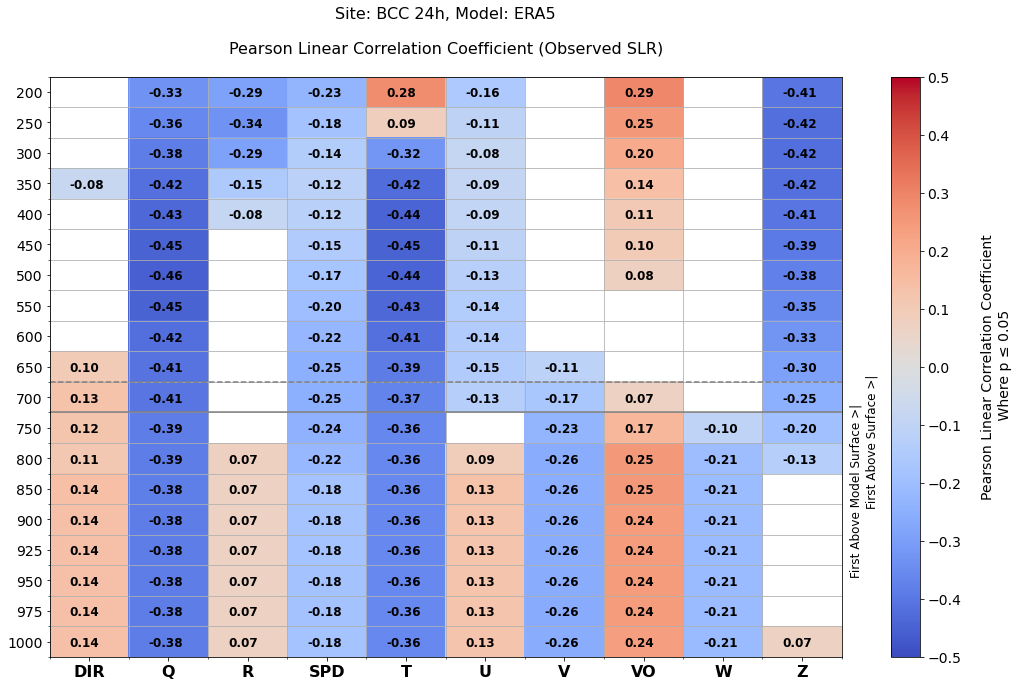

In [7]:
pval_cutoff = 0.05

lcc_composite = np.array([np.array(lcc[k])[:, 1] for k in era_vars]).T
pval_composite = np.array([np.array(pval[k])[:, 1] for k in era_vars]).T
lcc_composite[np.where(pval_composite > pval_cutoff)] = np.nan

fig, ax = plt.subplots(1, figsize=(15, 10), facecolor='w')

cbd = ax.pcolormesh(lcc_composite, vmin=-.5, vmax=.5, cmap='coolwarm')

shape = lcc_composite.shape
for x in range(lcc_composite.shape[1]):
    for y in range(shape[0]):
        if ~np.isnan(lcc_composite[y, x]):
            ax.text(x+.25, y+.65, '%.2f'%lcc_composite[y, x], fontsize=12, weight='bold')
            
ax.axhline(np.where(era_levels == lowest_era)[0], c='gray', linestyle='-')
ax.text(10.1, np.where(era_levels == lowest_era)[0]+5.3, 'First Above Model Surface >|', fontsize=12, rotation=90)

ax.axhline(np.where(era_levels == lowest_actual)[0], c='gray', linestyle='--')
ax.text(10.3, np.where(era_levels == lowest_era)[0]+3.03, 'First Above Surface >|', fontsize=12, rotation=90)

ax.set_xticks(np.arange(shape[1])+.5)
ax.set_xticklabels(lcc.keys(), fontsize=16, weight='bold')

ax.set_yticks(np.arange(shape[0])+.5)
ax.set_yticklabels(era_levels, fontsize=14)
ax.invert_yaxis()

cb = plt.colorbar(cbd)
cb.set_label('\nPearson Linear Correlation Coefficient\n Where p ≤ %s'%pval_cutoff, fontsize=14)
cb.set_ticks(np.arange(-0.5, .51, .1))
cb.ax.tick_params(labelsize=14)

ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))
ax.grid(True, 'minor')

ax.set_title('Site: %s %02dh, Model: %s\n\nPearson Linear Correlation Coefficient (Observed SLR)\n'%(site, interval, model), fontsize=16)

plt.tight_layout()
plt.show()

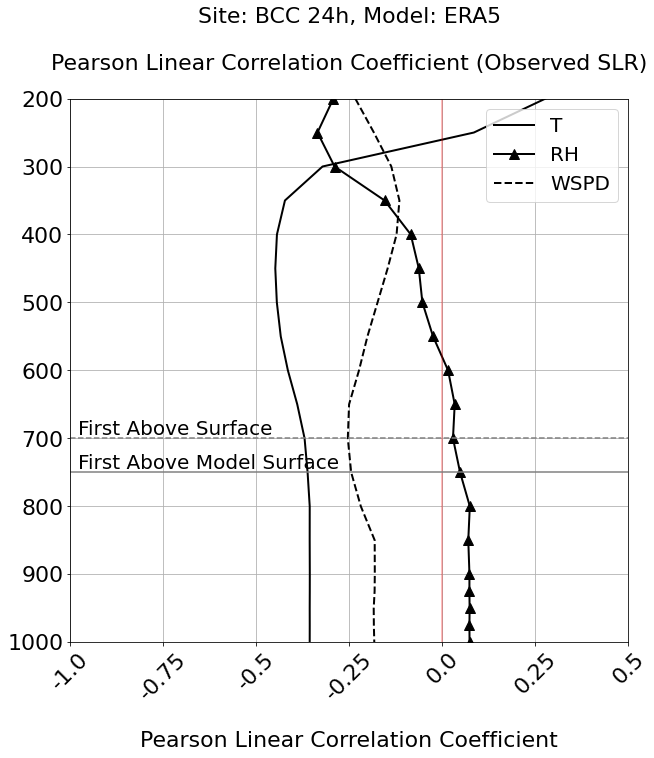

In [35]:
fig, ax = plt.subplots(1, figsize=(10, 10), facecolor='w')

ax.plot(lcc['T'][:, 1], lcc['T'][:, 0], color='k', linestyle='-', marker=None, linewidth=2, label='T')
ax.plot(lcc['R'][:, 1], lcc['T'][:, 0], color='k', linestyle='-', marker='^', markersize=10, linewidth=2, label='RH')
ax.plot(lcc['SPD'][:, 1], lcc['T'][:, 0], color='k', linestyle='--', marker=None, linewidth=2, label='WSPD')

ax.axvline(0, color='r', linestyle='-', alpha=0.35)
ax.axhline(lowest_era, c='gray', linestyle='-')
ax.axhline(lowest_actual, c='gray', linestyle='--')

ax.set_xticks(np.arange(-1, 1.1, .25))
ax.set_xticklabels(np.arange(-1, 1.1, .25), fontsize=22, rotation=45)
ax.set_xlabel('\nPearson Linear Correlation Coefficient', fontsize=22)

ax.set_yticks(np.arange(1000, 199, -50)[::2])
ax.set_yticklabels(np.arange(1000, 199, -50)[::2], fontsize=22)

ax.set_xlim([-1, .5])
ax.set_ylim([era_levels.max(), era_levels.min()])

ax.set_title('Site: %s %02dh, Model: %s\n\nPearson Linear Correlation Coefficient (Observed SLR)\n'%(site, interval, model), fontsize=22)

ax.legend(loc='upper right', fontsize=20)
ax.grid()

if lowest_actual == lowest_era:
    ax.text(-.98, lowest_actual+17, 'First Above Surface\nFirst Above Model Surface', fontsize=18)
else:
    ax.text(-.98, lowest_actual-5, 'First Above Surface', fontsize=20)
    ax.text(-.98, lowest_era-5, 'First Above Model Surface', fontsize=20)

plt.show()

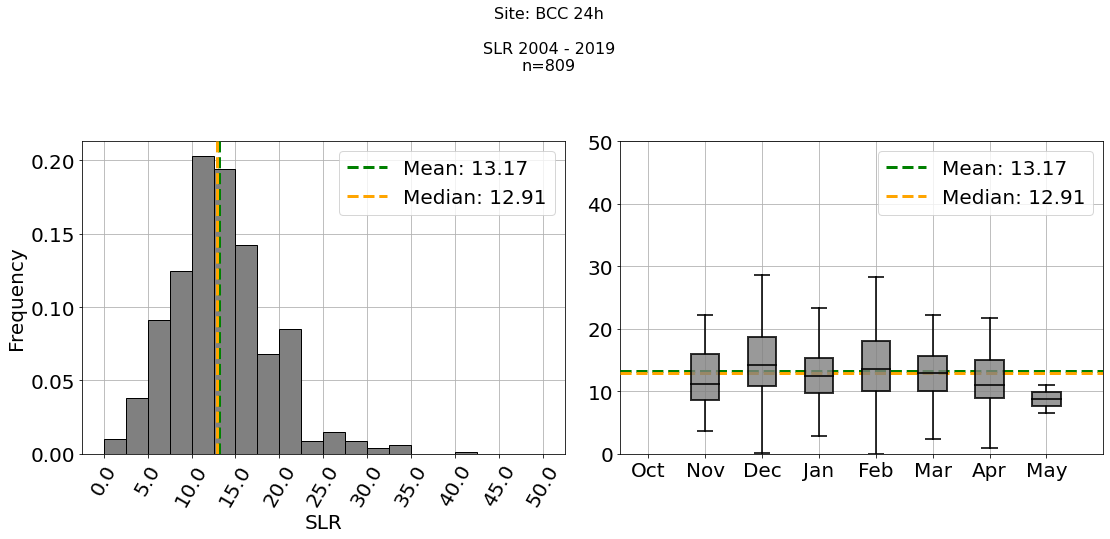

In [34]:
plt.rcParams.update({'font.size': 20})
binwidth = 2.5

fig, axs = plt.subplots(1, 2, figsize=(16, 8), facecolor='w')
    
histargs = {'width':1, 'color':'0.5', 'edgecolor':'k', 'zorder':10}
vlineargs = {'linewidth':3, 'linestyle':'--', 'zorder':11}
xyargs = {'s':150, 'marker':'+', 'linewidth':1.5, 'zorder':10}
    
v1, b1 = np.histogram(slr.values, bins=np.arange(0, 50+1, binwidth))    
axs[0].bar(np.arange(.5, len(v1), 1), v1/sum(v1), **histargs)

vmean = slr.mean()
axs[0].axvline(vmean/binwidth, c='green', label='Mean: %.2f'%vmean, **vlineargs)

vmed = slr.median()
axs[0].axvline(vmed/binwidth, c='orange', label='Median: %.2f'%vmed, **vlineargs)
    
axs[0].set_xticks(np.arange(len(b1))[::2])
axs[0].set_xticklabels(b1[::2], rotation=60)
axs[0].set_xlabel('SLR')
axs[0].set_ylabel('Frequency')

mobs = []
for i, month in enumerate([10, 11, 12, 1, 2, 3, 4, 5]):
    _mobs = slr.iloc[[i for i, t in enumerate(slr.index) if t.month == month]]
    _mobs = _mobs[~np.isnan(_mobs)]
    mobs.append(_mobs)

bp = axs[1].boxplot(mobs, showfliers=False, patch_artist=True, zorder=15)
[[box.set(linewidth=2, color='k', alpha=0.8) for box in bp[k]] 
     for k in ['boxes', 'whiskers', 'medians', 'means', 'caps']]
[patch.set_facecolor('0.5') for patch in bp['boxes']]

axs[1].axhline(vmean, c='green', label='Mean: %.2f'%vmean, **vlineargs)
axs[1].axhline(vmed, c='orange', label='Median: %.2f'%vmed, **vlineargs)

axs[1].set_xlim(right=9)
axs[1].set_ylim([0, 50])
axs[1].set_xticklabels(['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May'])

for ax in axs:
    ax.set_ylim(bottom=0)
    ax.legend()
    ax.grid()
    
plt.suptitle('Site: %s %02dh\n\nSLR %04d - %04d\nn=%d'%(site, interval, slr.index[0].year, slr.index[-1].year, slr.index.size), fontsize=16)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()